La Parité d'échange en jour de l'euro au dollar améericain du 1 janvier 2019 au 08 juin 2022

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [11]:
Data = pd.read_csv("/Users/toppapaissa/Desktop/Mémoire d'étude/EURUSD=X.csv", index_col='Date',parse_dates=True)

In [12]:
Data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,1.149425,1.155001,1.146500,1.149306,1.149306,0.0
2019-01-02,1.146132,1.149700,1.134572,1.146171,1.146171,0.0
2019-01-03,1.131734,1.140914,1.131734,1.131811,1.131811,0.0
2019-01-04,1.139095,1.141774,1.134816,1.139108,1.139108,0.0
2019-01-07,1.141292,1.147447,1.140524,1.141044,1.141044,0.0
...,...,...,...,...,...,...
2022-06-02,1.065417,1.073849,1.064566,1.065417,1.065417,0.0
2022-06-03,1.075107,1.076542,1.070664,1.075107,1.075107,0.0
2022-06-06,1.072605,1.075269,1.068604,1.072605,1.072605,0.0


In [13]:
Data.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [14]:
Data = Data.dropna(axis=0)


In [15]:
Data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,1.149425,1.155001,1.146500,1.149306,1.149306,0.0
2019-01-02,1.146132,1.149700,1.134572,1.146171,1.146171,0.0
2019-01-03,1.131734,1.140914,1.131734,1.131811,1.131811,0.0
2019-01-04,1.139095,1.141774,1.134816,1.139108,1.139108,0.0
2019-01-07,1.141292,1.147447,1.140524,1.141044,1.141044,0.0
...,...,...,...,...,...,...
2022-06-02,1.065417,1.073849,1.064566,1.065417,1.065417,0.0
2022-06-03,1.075107,1.076542,1.070664,1.075107,1.075107,0.0
2022-06-06,1.072605,1.075269,1.068604,1.072605,1.072605,0.0


In [16]:
df = Data.iloc[:,-2]

In [17]:
df

Date
2019-01-01    1.149306
2019-01-02    1.146171
2019-01-03    1.131811
2019-01-04    1.139108
2019-01-07    1.141044
                ...   
2022-06-02    1.065417
2022-06-03    1.075107
2022-06-06    1.072605
2022-06-07    1.069141
2022-06-08    1.074229
Name: Adj Close, Length: 896, dtype: float64

<AxesSubplot:xlabel='Date'>

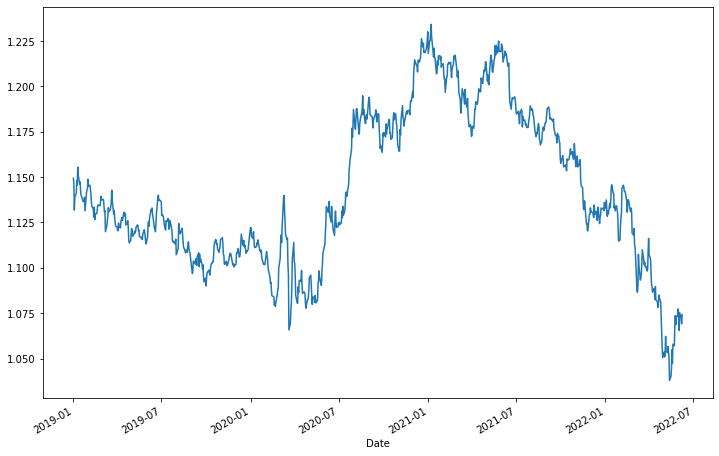

In [18]:
df.columns = ['change Euro-Dollar']
df.plot(figsize=(12,8))

En regardant le graphe, on voit que la variance ou la moyenne n'est pas constante dans le temps, du coup pas de stationnaire mais pour en être sûr on va faire le test de racine unitaire 

Avant de Constuire notre modèle, on s'assurer que la série est stationnaire :
    

- regarder la MA et l'ecart-type mobile sont constants dans le temps ; 


- ADF : Test de racine unitaire.

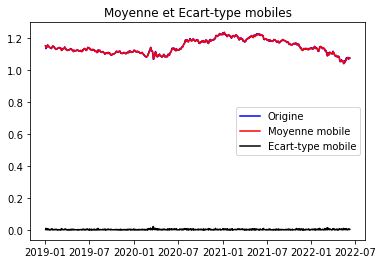

In [19]:
rolling_mean = df.rolling(window = 2).mean()
rolling_std = df.rolling(window = 2).std()
plt.plot(df, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

comme on peut le constater sur le graphique ci-dessus, la moyenne mobile n'est pas dans le temps

Répartition des données d'entrainement 

In [20]:
X= Data["Adj Close"].values
resultat = adfuller(X)


In [21]:
print('ADF: %f'  %resultat[0])
print('P-Value: %f'  %resultat[1])
print('valeurs critiques:')
for key, value in resultat[4].items():
    print('\t%s: %.3f' % (key, value))

if resultat[0] < resultat[4]["5%"]:
    print("On peut rejeter HO: on peut accepeter H1 alors puisque la série ne comporte pas de racine unitaire :la série est stationnaire")
else:
    print("On ne peut pas rejet HO, on l'accepte,la série comporte de racine unitaire: donc la série n'est pas stationnaire")

ADF: -1.233751
P-Value: 0.658911
valeurs critiques:
	1%: -3.438
	5%: -2.865
	10%: -2.568
On ne peut pas rejet HO, on l'accepte,la série comporte de racine unitaire: donc la série n'est pas stationnaire


La statistique ADF n'est pas proche des valeur critiques, raison plus pour conclure que la série n'est stationnaire 

On peut utiliser une méthode pour rendre la série stationnaire 

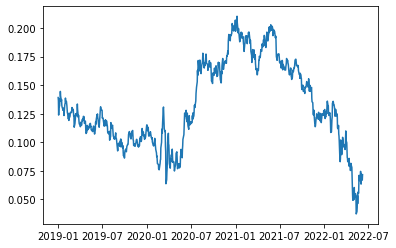

In [22]:
# Dans un premier temps, on va utiliser le log de la variable pour réduire le taux d'augmentation de la 
df_log = np.log(df)
plt.plot(df_log)

In [23]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=2).mean()
    rolling_std = timeseries.rolling(window=2).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

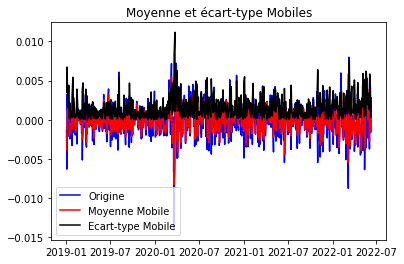

Statistiques ADF : -28.821489087739696
p-value : 0.0
Valeurs Critiques :
	1%: -3.4376857669714957
	5%: -2.864778351359889
	10%: -2.5684943199755765


In [24]:
rolling_mean = df_log.rolling(window=2).mean()

df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean)

Là! en se basant sur la p-value, on peut rejeter l'hypothèse nulle avec presque 0% de risque de se tromper alors qu'elle est vraie. On rejete Ho et accepter H1 autrement dit la série ne comporte pas de racine unitaire alors la série est stationnaire 

ACF and PACF

/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


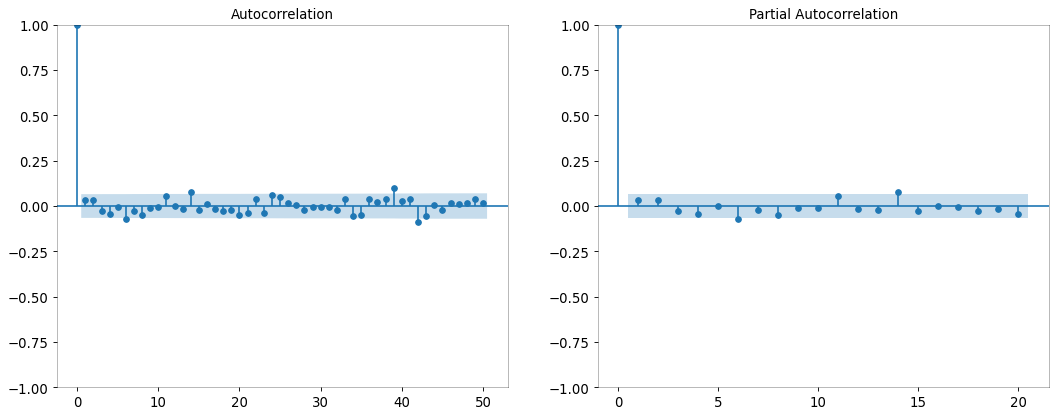

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df_log_minus_mean.tolist(), ax=ax1, lags=50)
plot_pacf(df_log_minus_mean.tolist(), ax=ax2, lags=20)

#
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

#La dimmenssion
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()


Pour voir lodre de différenciation avant d'implémenter le Modèle ARIMA

Sur les Données d'origine Df


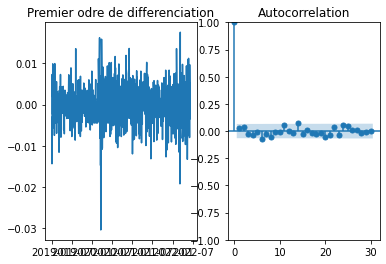

In [26]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Premier odre de differenciation')
ax1.plot(df.diff())

ax2 = f.add_subplot(122)
plot_acf(df.diff().dropna(), ax=ax2)
plt.show()


/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


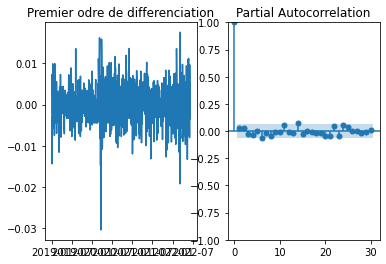

In [27]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Premier odre de differenciation')
ax1.plot(df.diff())

ax2 = f.add_subplot(122)
plot_pacf(df.diff().dropna(), ax=ax2)
plt.show()


ordre de diff = 2 nous semble bien mais on utilise le test de Duckey-Fuller pour en être sûr. 

In [28]:
resul = adfuller(df.dropna())
print('P_value', resul[1])

resul = adfuller(df.diff().dropna())
print('P_value', resul[1])

resul = adfuller(df.diff().diff().dropna())
print('P_value', resul[1])

P_value 0.6589112397508868
P_value 0.0
P_value 3.2509153347439025e-20


d est bien égal à 2

p= 1 en se basant sur la significativité de la PACF

q = 1 en se basant sur la signivicativité de la ACF

In [29]:
arima_model = ARIMA(df_log_minus_mean[:890], order= (1,2,1))
model1 = arima_model.fit()
print(model1.summary())

/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  890
Model:                 ARIMA(1, 2, 1)   Log Likelihood                4058.941
Date:                Mon, 10 Oct 2022   AIC                          -8111.881
Time:                        16:41:53   BIC                          -8097.514
Sample:                             0   HQIC                         -8106.389
                                - 890                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5139      0.021    -24.413      0.000      -0.555      -0.473
ma.L1         -0.9579      0.029    -32.753      0.000      -1.015      -0.901
sigma2      6.228e-06   2.98e-07     20.869      0.0

 Plus la valeur de l'AIC est faible, Meilleur est l'ajustement du modèle

Et la log-vriasemblance est beaucoup plus important par rapport au nombre de paramètres

Le coefficient d'asymétrie est négative: la distribution est décalée à droite de médiane et la queue de distribution decalée à gauche 

Le coefficient d'applatissement positif: les queues de la distribution comptent plus d'observations que dans une distribution guaussienne 
Le Kurtosis est positif : les queues de distribution sont plus épaisses 

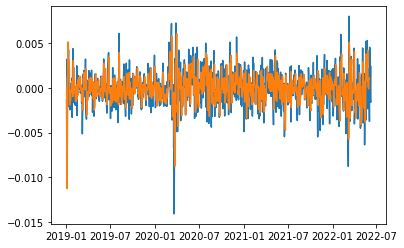

In [30]:
predictions_ARIMA_diff = pd.Series(model1.fittedvalues, copy=True)
plt.plot(df_log_minus_mean)
plt.plot(predictions_ARIMA_diff)

Le modele semlble bien appris

ON VA TESTER MAINTENANT SUR LES DONNÉES ORIGINES

In [31]:
arima_model_2 = ARIMA(df[:890], order= (1,2,1))
model2 = arima_model_2.fit()
print(model2.summary())

/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  890
Model:                 ARIMA(1, 2, 1)   Log Likelihood                3510.259
Date:                Mon, 10 Oct 2022   AIC                          -7014.518
Time:                        16:41:54   BIC                          -7000.151
Sample:                             0   HQIC                         -7009.026
                                - 890                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0351      0.032      1.108      0.268      -0.027       0.097
ma.L1         -0.9997      0.081    -12.346      0.000      -1.158      -0.841
sigma2      2.141e-05   1.84e-06     11.659      0.0

/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


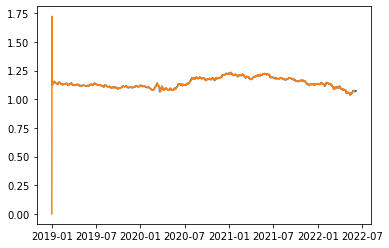

In [32]:
predictions_ARIMA_diff_2 = pd.Series(model2.fittedvalues, copy=True)
plt.plot(df)
plt.plot(predictions_ARIMA_diff_2)  #Pareil, le modèle semble bien appris

/Users/toppapaissa/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:>

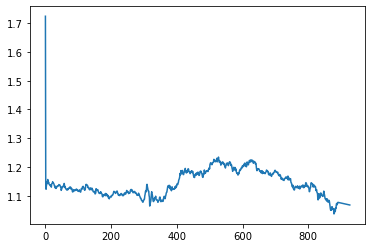

In [33]:
predictions = model2.predict(1, 926)
predictions.plot()


In [34]:
predictions[4]

1.1362095087182649

In [35]:
df[4]

1.141044

Érreur Quadratique Moyenne 

In [36]:
mse = mean_squared_error(df, predictions[:896])
print(mse)
#rmse = sqrt(mean_squared_error(test, predictions))

0.0003689784674668805


Racine Carrée des erreurs quadratique moyenne

In [37]:
from math import sqrt
rmse = sqrt(mean_squared_error(df, predictions[:896]))
rmse

0.01920881223467189

CONCLUSION : En se basant sur la minimisation des errreurs, notre modèle semble bien fonctioner dans les prédictions 

 ## DEEP LEARNING: LSTM 

Les données sont journalières, prévoyons 30 à 60 jours dans le futur

In [38]:
df = pd.read_excel("/Users/toppapaissa/Desktop/Mémoire d'étude/EURUSD_copie.xlsx", index_col='Date' ,parse_dates=True)
df.shape

(897, 1)

In [39]:
df = df.dropna(axis=0)
df.shape

(896, 1)

In [40]:
test_size = 90

In [41]:
test_ind = len(df)- test_size

In [42]:
test_ind

806

Données d'entrainement et de test 

In [43]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [44]:
#train = train1.array.reshape(-1, 1)
train

,Adj Close
Date,
2019-01-01,1.149306
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
...,...
2022-01-27,1.124354
2022-01-28,1.114703
2022-01-31,1.115237


In [45]:
test

,Adj Close
Date,
2022-02-03,1.129995
2022-02-04,1.143576
2022-02-07,1.145515
2022-02-08,1.144296
2022-02-09,1.142126
...,...
2022-06-02,1.065417
2022-06-03,1.075107
2022-06-06,1.072605


LA MISE EN ÉCHELLE DES DONNÉES 

In [46]:
scaler = MinMaxScaler()

In [47]:
scaler.fit(train)

MinMaxScaler()

In [48]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

GÉNÉRATEUR DE SÉRIES TEMPORELLES

In [49]:
# Redéfinissons pour obtenir 30 jours en arrière et prédisons le mois suivant
length = 60
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [50]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [51]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.49633558 0.47771654 0.39243123 0.43576876 0.44726683 0.48842472
 0.47436689 0.5330926  0.50647361 0.4767841  0.48435644 0.45106191
 0.43993206 0.43669525 0.42061814 0.4228453  0.41969758 0.43407018
 0.38969331 0.44881693 0.45888963 0.46207298 0.49312254 0.47047085
 0.47389771 0.46261344 0.44696394 0.42084976 0.40470138 0.39608376
 0.36922721 0.40226042 0.36085309 0.37891386 0.38050554 0.38877869
 0.40721956 0.40920915 0.40721956 0.40676225 0.42177032 0.43699815
 0.42930109 0.42530408 0.4267651  0.40385803 0.38589229 0.3899962
 0.32129282 0.34153917 0.35746187 0.37422198 0.40012235 0.38665249
 0.39341711 0.40317504 0.41425738 0.45764836 0.42622464 0.37921675]
Cela prédit ce y : 
 [[0.3910593]]


## CRÉATION DE NOTRE MODÈLE 

In [52]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [82]:
# définir le modèle
model = Sequential()
model.add(LSTM(70, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 70)                20160     
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 20,233
Trainable params: 20,233
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

In [85]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [86]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [87]:
# ajustement du modèle
model.fit(generator,epochs=12,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/12
851/851 [==============================] - 19s 21ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 2/12
851/851 [==============================] - 18s 21ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 3/12
851/851 [==============================] - 19s 22ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 4/12
851/851 [==============================] - 19s 23ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/12
851/851 [==============================] - 20s 23ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 6/12
851/851 [==============================] - 21s 24ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 7/12
851/851 [==============================] - 21s 24ms/step - loss: 8.5133e-04 - val_loss: 0.0027


In [88]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

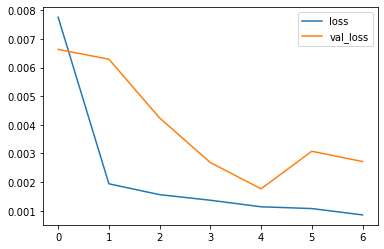

In [89]:
losses.plot()

## Évaluation sur les données de test

In [90]:
first_eval_batch = scaled_train[-length:]
first_eval_batch.shape

(45, 1)

In [91]:
first_eval_batch = first_eval_batch.reshape((1 ,length, n_features))
first_eval_batch.shape

(1, 45, 1)

In [92]:
model.predict(first_eval_batch)

array([[0.35814705]], dtype=float32)

In [93]:
scaled_test[0]

array([0.38164584])

Mettons maintenant cette logique dans une boucle for pour prédire l'avenir pour toute la gamme de test.


In [94]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Transformations inverses et Comparaison

In [95]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[1.12603837],
       [1.1275985 ],
       [1.12897982],
       [1.13021976],
       [1.13134516],
       [1.132379  ],
       [1.13334032],
       [1.13424442],
       [1.1351033 ],
       [1.13592624],
       [1.1367202 ],
       [1.13749051],
       [1.13824026],
       [1.13897145],
       [1.13968556],
       [1.14038364],
       [1.14106657],
       [1.14173504],
       [1.14238961],
       [1.14303079],
       [1.14365903],
       [1.14427473],
       [1.14487828],
       [1.14547008],
       [1.14605043],
       [1.14661969],
       [1.14717823],
       [1.14772652],
       [1.1482651 ],
       [1.14879427],
       [1.14931431],
       [1.14982543],
       [1.15032782],
       [1.15082169],
       [1.15130722],
       [1.1517846 ],
       [1.15225403],
       [1.15271569],
       [1.15316977],
       [1.15361648],
       [1.15405599],
       [1.15448848],
       [1.15491416],
       [1.15533318],
       [1.1557457 ],
       [1.15615193],
       [1.15655197],
       [1.156

In [96]:
test['Predictions'] = true_predictions

/var/folders/8h/w2t_kch528g1q2jsx_0q9pm80000gn/T/ipykernel_40356/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [97]:
test

,Adj Close,Predictions
Date,,
2022-02-03,1.129995,1.126038
2022-02-04,1.143576,1.127598
2022-02-07,1.145515,1.128980
2022-02-08,1.144296,1.130220
2022-02-09,1.142126,1.131345
...,...,...
2022-06-02,1.065417,1.168595
2022-06-03,1.075107,1.168836
2022-06-06,1.072605,1.169074


<AxesSubplot:xlabel='Date'>

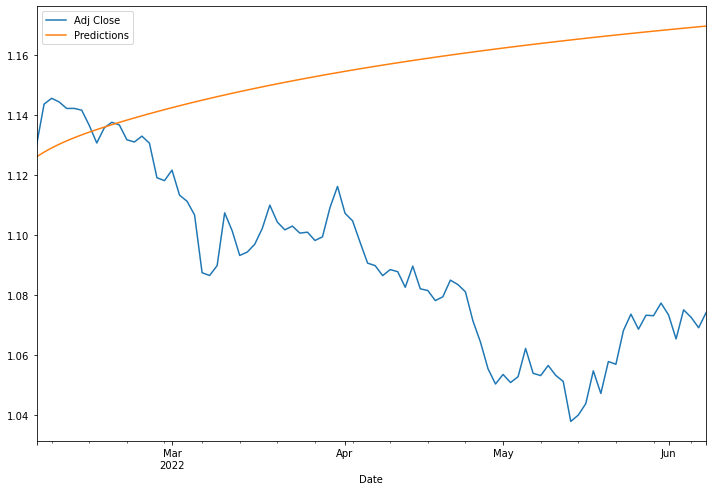

In [98]:
test.plot(figsize=(12,8))

In [99]:
#test['predictions'] = true_predictions

In [100]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)


In [101]:

length = 45 # Longueur des séquences de sortie (en nombre de pas temporel)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [102]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# ajustement du modèle
model.fit(generator,epochs=8)

Epoch 1/8
851/851 [==============================] - 17s 19ms/step - loss: 0.0055
Epoch 2/8
851/851 [==============================] - 21s 24ms/step - loss: 0.0021
Epoch 3/8
851/851 [==============================] - 19s 22ms/step - loss: 0.0017
Epoch 4/8
851/851 [==============================] - 20s 23ms/step - loss: 0.0014
Epoch 5/8
851/851 [==============================] - 22s 25ms/step - loss: 0.0012
Epoch 6/8
851/851 [==============================] - 18s 21ms/step - loss: 0.0011
Epoch 7/8
851/851 [==============================] - 20s 24ms/step - loss: 9.5653e-04
Epoch 8/8
851/851 [==============================] - 22s 25ms/step - loss: 9.3492e-04


In [103]:
forecast = []
# Remplacez les périodes par la durée de prévision que vous souhaitez
periods = 30

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [104]:
forecast = full_scaler.inverse_transform(forecast)

In [105]:
df

,Adj Close
Date,
2019-01-01,1.149306
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
...,...
2022-06-02,1.065417
2022-06-03,1.075107
2022-06-06,1.072605


In [106]:
forecast_index = pd.date_range(start='2022-06-09',periods=periods,freq='D')

In [107]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [108]:
forecast_df

,Forecast
2022-06-09,1.069062
2022-06-10,1.066965
2022-06-11,1.064627
2022-06-12,1.062246
2022-06-13,1.059905
2022-06-14,1.057659
2022-06-15,1.055523
2022-06-16,1.053502
2022-06-17,1.051598
2022-06-18,1.049821


<AxesSubplot:>

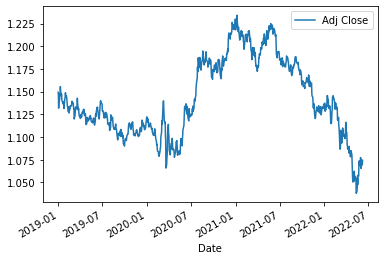

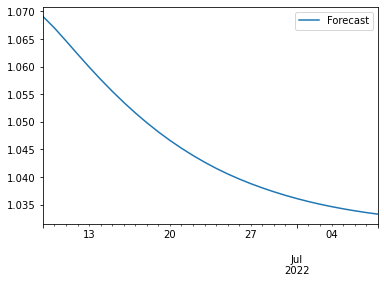

In [109]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='Date'>

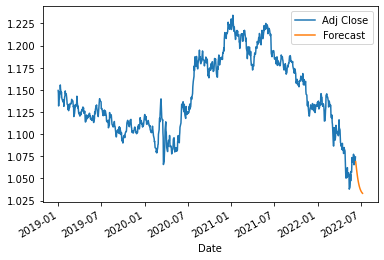

In [110]:
ax = df.plot()
forecast_df.plot(ax=ax)

Notre Modèle ne fait pas la meilleur perf mais semble bien marché vu que le temps nous a donné raison puiqque au debut du mois de juillet 2022, on a assité une parité Euro+Dollar après 20ans.
chute Progressive entre de l'euro par rapport au dollar........